In [1]:
print("Hello World!")

[1] "Hello World!"


In [2]:
library(rmweather)

In [3]:
help(rmweather)

No documentation for ‘rmweather’ in specified packages and libraries:
you could try ‘??rmweather’

In [4]:
??rmweather

R Information

Help files with alias or concept or title matching ‘rmweather’ using
fuzzy matching:


rmweather::data_london
                        Example observational data for the *rmweather*
                        package.
rmweather::data_london_normalised
                        Example of meteorologically normalised data for
                        the *rmweather* package.
rmweather::model_london
                        Example *ranger* random forest model for the
                        *rmweather* package.
rmweather::rmw_partial_dependencies
                        Function to calculate partial dependencies
                        after training with *rmweather*.
rmweather::rmw_prepare_data
                        Function to prepare a data frame for modelling
                        with *rmweather*.


Type '?PKG::FOO' to inspect entries 'PKG::FOO', or 'TYPE?PKG::FOO' for
entries like 'PKG::FOO-TYPE'.





Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




date,date_end,site,site_name,variable,value,air_temp,atmospheric_pressure,rh,wd,ws
<dttm>,<dttm>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1997-07-17,1997-07-17 23:59:59,gb0682a,London Marylebone Road,no2,77.48,16.64,1014.74,80.49,294.42,2.95
1997-07-18,1997-07-18 23:59:59,gb0682a,London Marylebone Road,no2,54.39,16.08,1019.57,77.04,343.20,3.91
1997-07-19,1997-07-19 23:59:59,gb0682a,London Marylebone Road,no2,56.17,19.04,1026.18,63.64,23.63,3.11
1997-07-20,1997-07-20 23:59:59,gb0682a,London Marylebone Road,no2,63.22,19.62,1026.14,57.25,32.36,2.67
1997-07-21,1997-07-21 23:59:59,gb0682a,London Marylebone Road,no2,80.35,20.42,1023.74,54.12,48.53,2.36
1997-07-22,1997-07-22 23:59:59,gb0682a,London Marylebone Road,no2,84.65,20.95,1020.89,52.46,357.46,1.29


2021-12-09 20:30:07.180 CET: Checking input data...

2021-12-09 20:30:07.215 CET: Model training started...

2021-12-09 20:30:07.991 CET: Sampling and predicting 300 times...

2021-12-09 20:30:08.399 CET: Predicting 5 of 300 times (1.67 %)...

2021-12-09 20:30:08.920 CET: Predicting 10 of 300 times (3.33 %)...

2021-12-09 20:30:09.457 CET: Predicting 15 of 300 times (5.0 %)...

2021-12-09 20:30:09.997 CET: Predicting 20 of 300 times (6.67 %)...

2021-12-09 20:30:10.508 CET: Predicting 25 of 300 times (8.33 %)...

2021-12-09 20:30:11.019 CET: Predicting 30 of 300 times (10.0 %)...

2021-12-09 20:30:11.544 CET: Predicting 35 of 300 times (11.67 %)...

2021-12-09 20:30:12.086 CET: Predicting 40 of 300 times (13.33 %)...

2021-12-09 20:30:12.602 CET: Predicting 45 of 300 times (15.0 %)...

2021-12-09 20:30:13.114 CET: Predicting 50 of 300 times (16.67 %)...

2021-12-09 20:30:13.628 CET: Predicting 55 of 300 times (18.33 %)...

2021-12-09 20:30:14.154 CET: Predicting 60 of 300 times (20.0 %

[1] "observations"  "model"         "n_samples"     "normalised"   
[5] "elapsed_times"

n_trees,mtry,min_node_size,importance_mode,count_independent_variables,independent_variables,count_samples,prediction_error_mse,r_squared
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>
300,2,5,permutation,8,date_unix; day_julian; weekday; air_temp; rh; wd; ws; atmospheric_pressure,6171,256.1569,0.7628745


Warning message:
“Computation failed in `stat_binhex()`:
The `hexbin` package is required for `stat_binhex()`”


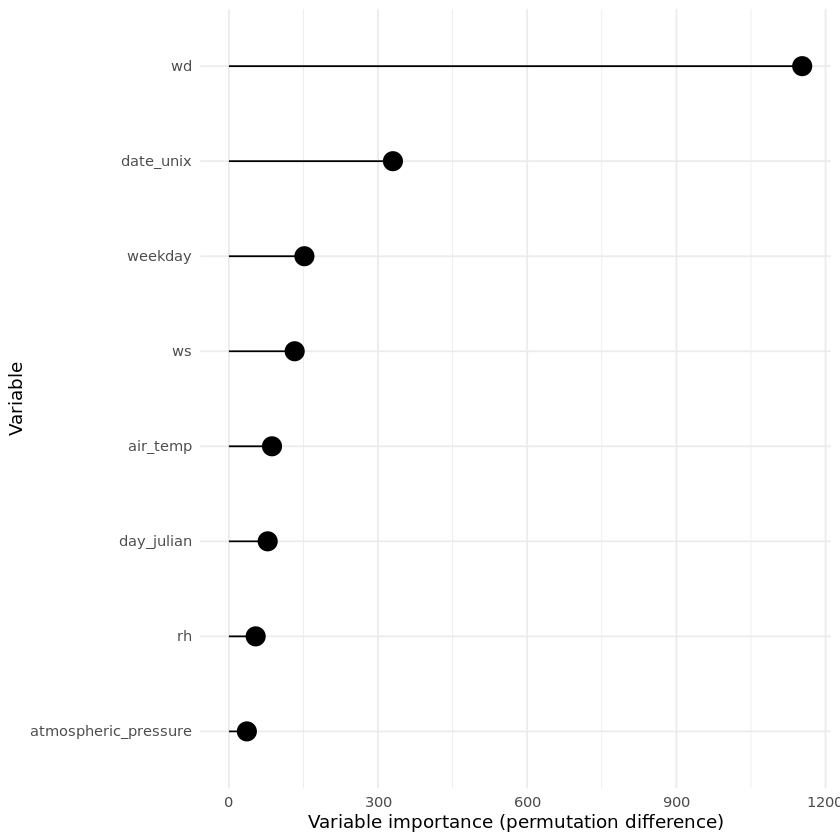

hostname,date_start,date_post_training,date_post_normalise,time_elasped_training,time_elapsed_normalising,time_elapsed_total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bastet01,1639078207,1639078208,1639078240,0.7818668,31.548,32.32986


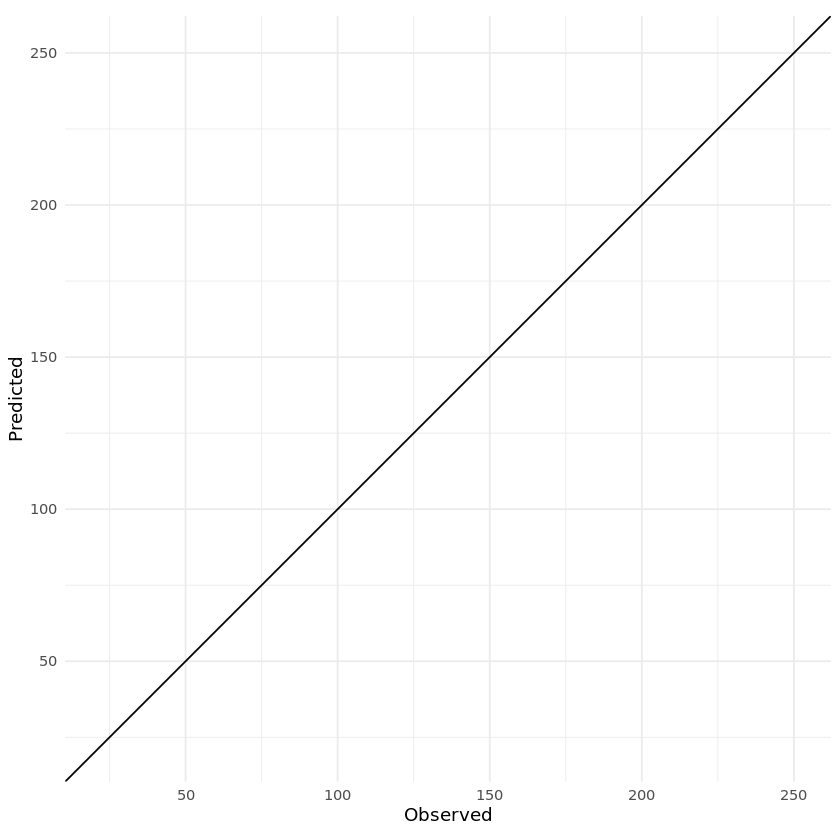

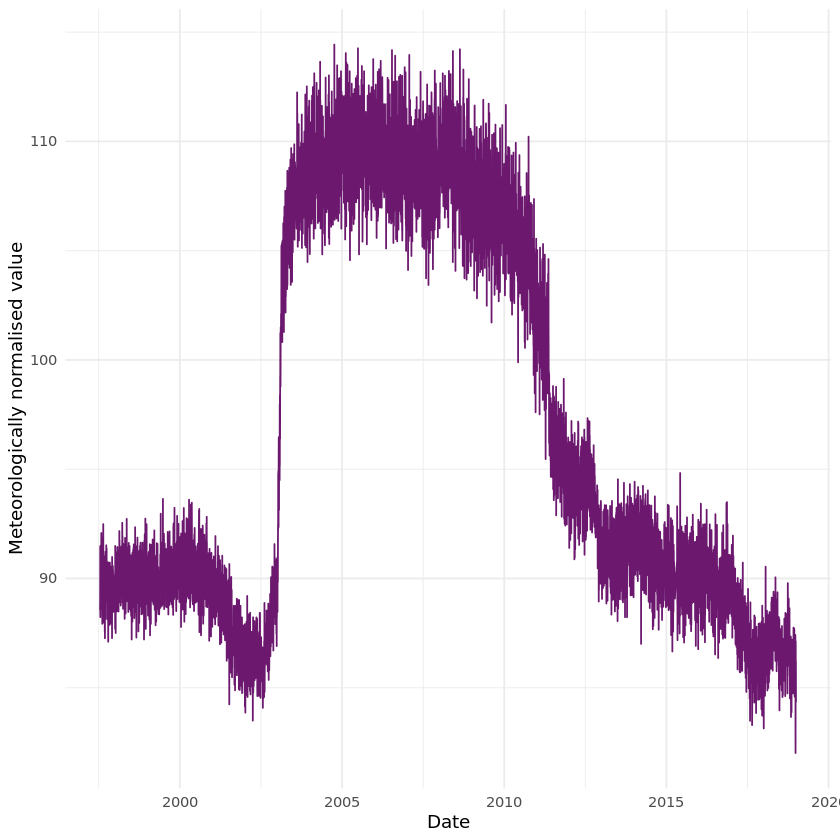

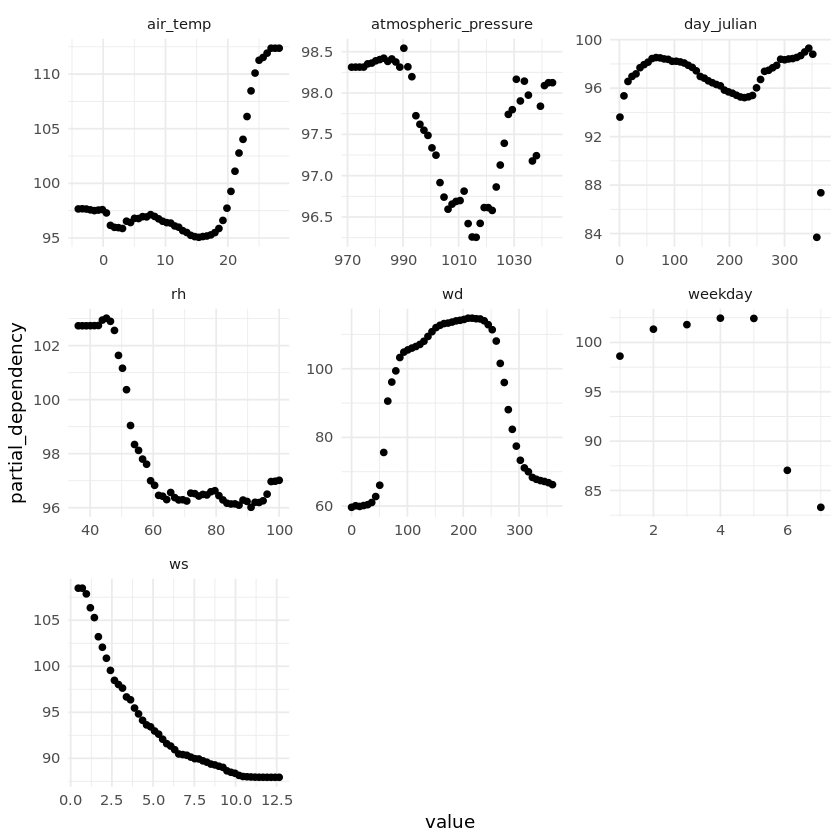

In [5]:
# Load packages
library(dplyr)
library(rmweather)
library(ranger)

# Have a look at rmweather's example data, from london
head(data_london)

# Prepare data for modelling
# Only use data with valid wind speeds, no2 will become the dependent variable
data_london_prepared <- data_london %>% 
  filter(variable == "no2",
         !is.na(ws)) %>% 
  rmw_prepare_data(na.rm = TRUE)

# Grow/train a random forest model and then create a meteorological normalised trend 
list_normalised <- rmw_do_all(
  data_london_prepared,
  variables = c(
    "date_unix", "day_julian", "weekday", "air_temp", "rh", "wd", "ws",
    "atmospheric_pressure"
  ),
  n_trees = 300,
  n_samples = 300,
  verbose = TRUE
)

# What units are in the list? 
names(list_normalised)

# Check model object's performance
rmw_model_statistics(list_normalised$model)

# Plot variable importances
list_normalised$model %>% 
  rmw_model_importance() %>% 
  rmw_plot_importance()

# Check if model has suffered from overfitting
rmw_predict_the_test_set(
  model = list_normalised$model,
  df = list_normalised$observations
) %>% 
  rmw_plot_test_prediction()

# How long did the process take? 
list_normalised$elapsed_times

# Plot normalised trend
rmw_plot_normalised(list_normalised$normalised)

# Investigate partial dependencies, if variable is NA, predict all
data_pd <- rmw_partial_dependencies(
  model = list_normalised$model, 
  df = list_normalised$observations,
  variable = NA
)

# Plot partial dependencies
data_pd %>% 
  filter(variable != "date_unix") %>% 
  rmw_plot_partial_dependencies()